In [ ]:
pip install -q gdown

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
import gdown

file_id = "1xIEYRlNkynJkPLldtx9vEq7N9DOKn9ql"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1xIEYRlNkynJkPLldtx9vEq7N9DOKn9ql
From (redirected): https://drive.google.com/uc?id=1xIEYRlNkynJkPLldtx9vEq7N9DOKn9ql&confirm=t&uuid=b2f5bb79-a899-4bb3-b15e-be895b2730b2
To: /content/dataset.zip
100%|██████████| 1.44G/1.44G [00:18<00:00, 76.3MB/s]


'dataset.zip'

In [3]:
import zipfile

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [ ]:
import os

print(os.listdir("dataset"))

['img_align_celeba']


In [4]:
ATTR_FILE = '/content/list_attr_celeba.csv'
IMG_DIR = '/content/dataset/img_align_celeba'

attrs_df = pd.read_csv(ATTR_FILE)

# Convert -1 to 0
attrs_df['Eyeglasses'] = (attrs_df['Eyeglasses'] + 1) // 2
attrs_df['Male'] = (attrs_df['Male'] + 1) // 2

print(attrs_df.columns)
print(attrs_df.head())

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1        

In [5]:
class CelebADataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def extract_shirt_color(self, img_np):
        shirt_region = img_np[int(img_np.shape[0]*0.6):, :]
        shirt_region = shirt_region.reshape((-1, 3))
        kmeans = KMeans(n_clusters=1).fit(shirt_region)
        return kmeans.cluster_centers_[0].astype(int)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image_id'])
        image = Image.open(image_path).convert('RGB')
        image_np = np.array(image)

        if self.transform:
            image = self.transform(image)

        gender = torch.tensor(row['Male'], dtype=torch.float32)
        glasses = torch.tensor(row['Eyeglasses'], dtype=torch.float32)
        shirt_rgb = self.extract_shirt_color(image_np) / 255.0
        shirt_rgb = torch.tensor(shirt_rgb, dtype=torch.float32)

        return image, gender, glasses, shirt_rgb


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Split
train_df = attrs_df.iloc[:15000]
val_df = attrs_df.iloc[15000:17000]

train_dataset = CelebADataset(train_df, IMG_DIR, transform)
val_dataset = CelebADataset(val_df, IMG_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [7]:
class MultiTaskResNet(nn.Module):
    def __init__(self):
        super(MultiTaskResNet, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()

        self.gender = nn.Linear(512, 1)
        self.glasses = nn.Linear(512, 1)
        self.shirt = nn.Linear(512, 3)

    def forward(self, x):
        x = self.backbone(x)
        return torch.sigmoid(self.gender(x)), torch.sigmoid(self.glasses(x)), self.shirt(x)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskResNet().to(device)

criterion_bce = nn.BCELoss()
criterion_mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_epoch():
    model.train()
    for imgs, gender, glasses, shirt in train_loader:
        imgs, gender, glasses, shirt = imgs.to(device), gender.to(device), glasses.to(device), shirt.to(device)
        optimizer.zero_grad()
        out_gender, out_glasses, out_shirt = model(imgs)

        loss = (
            criterion_bce(out_gender.squeeze(), gender) +
            criterion_bce(out_glasses.squeeze(), glasses) +
            criterion_mse(out_shirt, shirt)
        )
        loss.backward()
        optimizer.step()

for epoch in range(3):
    train_epoch()
    print(f"Epoch {epoch+1} complete")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


Epoch 1 complete
Epoch 2 complete
Epoch 3 complete


Gender Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1164
         1.0       0.97      0.91      0.94       836

    accuracy                           0.95      2000
   macro avg       0.95      0.94      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Glasses Detection Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1877
         1.0       0.91      0.97      0.94       123

    accuracy                           0.99      2000
   macro avg       0.95      0.98      0.97      2000
weighted avg       0.99      0.99      0.99      2000



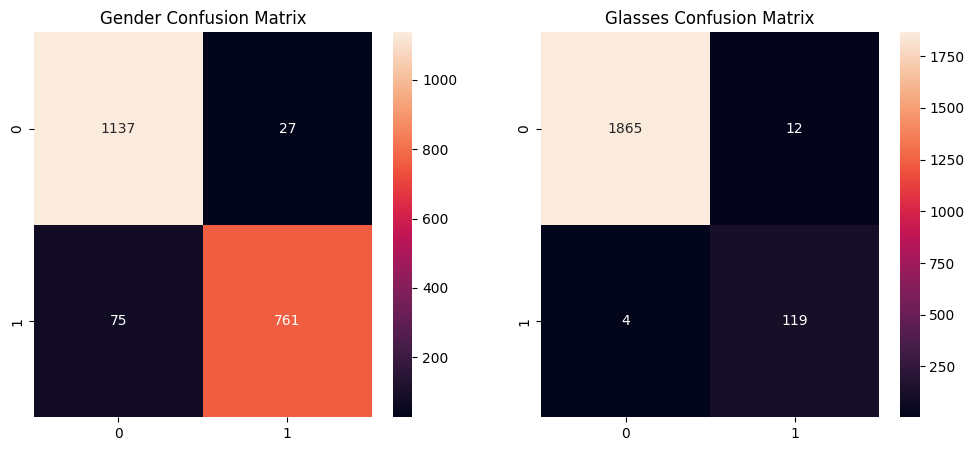

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate():
    model.eval()
    y_true_gender, y_pred_gender = [], []
    y_true_glasses, y_pred_glasses = [], []

    with torch.no_grad():
        for imgs, gender, glasses, _ in val_loader:
            imgs = imgs.to(device)
            g_true = gender.numpy()
            gl_true = glasses.numpy()
            g_pred, gl_pred, _ = model(imgs)

            y_true_gender.extend(g_true)
            y_pred_gender.extend((g_pred.cpu().numpy() > 0.5).astype(int))
            y_true_glasses.extend(gl_true)
            y_pred_glasses.extend((gl_pred.cpu().numpy() > 0.5).astype(int))

    print("Gender Classification Report:")
    print(classification_report(y_true_gender, y_pred_gender))

    print("Glasses Detection Report:")
    print(classification_report(y_true_glasses, y_pred_glasses))

    # Confusion matrix
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(confusion_matrix(y_true_gender, y_pred_gender), annot=True, ax=axs[0], fmt="d")
    axs[0].set_title("Gender Confusion Matrix")

    sns.heatmap(confusion_matrix(y_true_glasses, y_pred_glasses), annot=True, ax=axs[1], fmt="d")
    axs[1].set_title("Glasses Confusion Matrix")

evaluate()


In [11]:
def predict_on_external_image(path):
    image = Image.open(path).convert("RGB")
    image_np = np.array(image)

    transform_ext = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image_tensor = transform_ext(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        g, gl, shirt_rgb = model(image_tensor)

    gender = "Male" if g.item() > 0.5 else "Female"
    glasses = "Yes" if gl.item() > 0.5 else "No"
    shirt_rgb = shirt_rgb.squeeze().cpu().numpy()
    shirt_rgb = np.clip(shirt_rgb * 255, 0, 255).astype(int)

    print(f"Gender: {gender}")
    print(f"Glasses: {glasses}")
    print(f"Shirt Color (RGB): {shirt_rgb}")
    plt.imshow(image)
    plt.title(f"{gender}, Glasses: {glasses}")
    plt.show()


Gender: Male
Glasses: Yes
Shirt Color (RGB): [169 141  98]


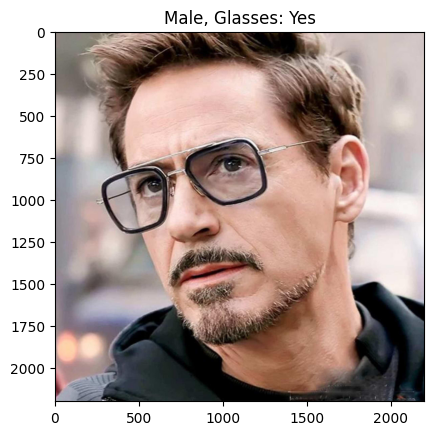

In [18]:
predict_on_external_image("/content/test.jpg")

In [24]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  uploaded_img_path = fn

Gender: Female
Glasses: No
Shirt Color (RGB): [213 110 118]


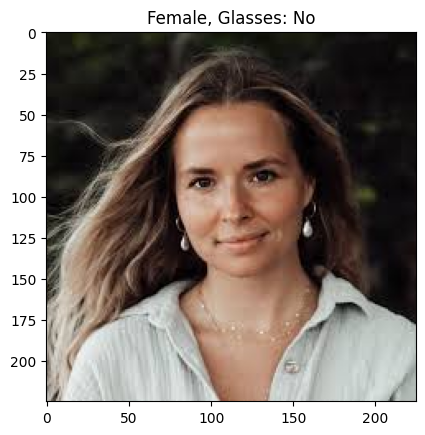

In [23]:
predict_on_external_image(uploaded_img_path)